<a href="https://colab.research.google.com/github/mbibrahe/BA_Project/blob/main/DBSCAN_bgSub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import glob, os, numpy as np
from keras.preprocessing import image as kImage
from __future__ import print_function
import numpy as np
import random as rn
import os
from tensorflow.compat.v1.keras import backend as K

import numpy as np

from PIL import Image as PILimage
import matplotlib.pyplot as plt
from matplotlib import image as imageMat
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image as Image
from sklearn.datasets import load_sample_image
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
import cv2 as cv
from numba import vectorize, jit, cuda 


import sys, time

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials





In [2]:

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [3]:
download = drive.CreateFile({'id': '12Kps2O0x-kxQyqBKJFs-xeSenpggMAEe'})
download.GetContentFile("16_samples.zip")


! unzip 16_samples.zip

from google.colab import drive
drive.mount ('/content/drive')

Streaming output truncated to the last 5000 lines.
  inflating: 16_samples/train/z/2/bg2 - Copy (675) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (676) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (677) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (678) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (679) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (68) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (68) - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (680) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (681) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (682) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (683) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (684) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/bg2 - Copy (685) - Copy - Copy.jpg  
  inflating: 16_samples/train/z/2/b

In [12]:



dataset_path = os.path.join('16_samples')
def getData(dataset_dir):
    X_list11= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','1','*.jpg')))
    #X_list11= sorted(glob.glob(os.path.join(dataset_path, 'input', '*.jpg')))
    

    X_gray= []
    X= []



    #Run for less frames
    for i in range(0, len(X_list11), 2):
        
        # Load input image
        x_gray = cv.imread(X_list11[i], 0)
        x_gray = cv.normalize(x_gray, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        X_gray.append(x_gray)



        x = cv.imread(X_list11[i])
        X.append(x)

    X_gray = np.asarray(X_gray)
    X = np.asarray(X)

    return X_gray, X

X_gray, X = getData(dataset_path)

In [13]:

import heapq
import statistics
from collections import Counter



#Code for fix_photo:
#https://github.com/vimlord/Clustering-Background-Subtraction


#Epsilon is the maximum distance between to samples, for them to be clustered in the same neighborhood
#Min_points is the minimum number of samples in a neighborhood for a data point to qualify as a core point 
#Frames = out dataset, eps = the optimal calculated epsilon, minPts = dataset dim*2

def fix_photo(frames, grey_frames, eps=0.00):
    #eps_ = nn_epsilon(grey_frames)

    minPts = (len(frames.shape) - 1 ) * 2
    print(minPts)
    
    shape = (len(frames), len(frames[0]), len(frames[0][0]))
    
    image = []

    bar_width = 40
    bar_prog = 0
    start = time.time()
    
    sys.stdout.write("Running DBSCAN...\nProgress: 0/" + str(shape[1]) + " [" + (bar_width * " ") + "] ETA: N/A")
    sys.stdout.flush()
    #iterate through rows
    for r in range(0, shape[1]):
        row = []
        #iterate through cols
        for c in range(0, shape[2]):

            #Create temp array of current r, c pixel for EVERY frame in the original video.
            #This means, we create an array of length 200, where each element is the rgb values, 
            #for pixel at location 1,1, then at location 1,2 and so on.
            pixels = np.array([frame[r][c] for frame in frames])
            

            nbrs = NearestNeighbors(n_neighbors=2).fit(pixels)
            distances, indices = nbrs.kneighbors(pixels)
            distances = distances[:,1]
            
            temp_eps = sum(distances)/len(distances)
            
            #https://github.com/facebookresearch/faiss/issues/297
            #If any distances values are negativ because of a roundoff error
            #Or if any distances are zero
            epsilon = abs(temp_eps) + 0.00001
            
            
            
            db = DBSCAN(eps=epsilon, min_samples=minPts).fit(pixels)

            
            
            # Grab label information.
            labels = db.labels_
            
            label_set = set(labels)
            label_count = {l : 0 for l in label_set}
            
            # Compute label frequency
            for l in labels:
                label_count[l] += 1

            # This is only used for videos with objects that are stationary for most of the video
            # and is therefore not used in this case.
            freq_ = Counter(labels)
            a = freq_.most_common(1)

            l_ = []

            l_.append(a[0][0])


            # Choose a cluster.
            choice = None
            for l in label_set:
                if choice is None or label_count[choice] < label_count[l] and (l != -1):
                    choice = l
            
            # Apply the pixel if it exists.
            if choice is None:
                row.append(np.mean(pixels, axis=0))
            else:
                row.append(np.mean(np.array([pixels[i] for i in range(len(labels)) if labels[i] == choice]), axis=0))
                   
        # Provide the image
        image.append(row)
        
        # Bar progress
        bar_prog = int((bar_width * (r+1.)) / shape[1])
        
        # Time remaining
        t = time.time() - start
        t = (shape[1] * t / (r+1.0)) - t

        sys.stdout.write("\rProgress: " + str(r+1) + "/" + str(shape[1]) + " [" + ("#" * bar_prog) + (" " * (bar_width - bar_prog)) + "] ETA: ")
        sys.stdout.write(time.strftime("%H hr %M min", time.gmtime(t)))
        sys.stdout.flush()

    sys.stdout.write("\rProgress: " + str(shape[1]) + "/" + str(shape[1]) + " [" + ("#" * bar_prog) + (" " * (bar_width - bar_prog)) + "] Done! ")

    print(time.strftime("(Time: %H hr %M min)", time.gmtime(time.time() - start)))

    return image



res = np.array(fix_photo(X, X)).astype(np.uint8)





6
Running DBSCAN...
Progress: 240/240 [########################################] Done! (Time: 00 hr 07 min)


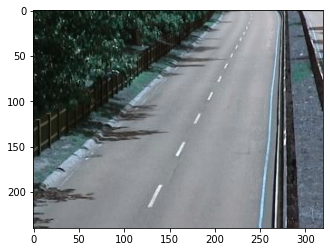

In [14]:
plt.imshow(res)
plt.show()

In [15]:
cv.imwrite ('/content/drive/My Drive/NewImage.jpg', res)

True